In [1]:
import sys, os
from tqdm import tqdm
from PIL import Image
import json
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import sys
from typing import *
import numpy as np
import matplotlib.pyplot as plt


sys.path.append(os.getcwd())

/home/raj/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
class IMDBDataset2(Dataset):
    """Implements a torch Dataset class for the imdb dataset."""
    
    def __init__(self, file: h5py.File, start_ind: int, end_ind: int, vggfeature: bool = False) -> None:
        """Initialize IMDBDataset object.

        Args:
            file (h5py.File): h5py file of data
            start_ind (int): Starting index for dataset
            end_ind (int): Ending index for dataset
            vggfeature (bool, optional): Whether to return pre-processed vgg_features or not. Defaults to False.
        """
        self.file = file
        self.start_ind = start_ind
        self.size = end_ind-start_ind
        self.vggfeature = vggfeature

    def __getitem__(self, ind):
        """Get item from dataset.

        Args:
            ind (int): Index of data to get

        Returns:
            tuple: Tuple of text input, image input, and label
        """
        if not hasattr(self, 'dataset'):
            self.dataset = h5py.File(self.file, 'r')
        text = self.dataset["features"][ind+self.start_ind]
        image = self.dataset["images"][ind+self.start_ind] if not self.vggfeature else \
            self.dataset["vgg_features"][ind+self.start_ind]
        label = self.dataset["genres"][ind+self.start_ind]

        return text, image, label

    def get_item_by_id(self, imdb_id: str):
        """Get item from dataset by imdb_id.

        Args:
            imdb_id (str): IMDB ID to get
        """
        text = self.dataset["features"][self.dataset["imdb_ids"].index(imdb_id)]
        image = self.dataset["images"][self.dataset["imdb_ids"].index(imdb_id)] if not self.vggfeature else \
            self.dataset["vgg_features"][self.dataset["imdb_ids"].index(imdb_id)]
        label = self.dataset["genres"][self.dataset["imdb_ids"].index(imdb_id)]
        return text, image, label
    
    def get_raw(self, imdb_id, file_path):
        # REad from the the file, based on the imdb_id
        imdb_id = str(imdb_id[2:-1])
        file_name = file_path + '/' + imdb_id + '.json'
        with open(file_name, 'r') as f:
            data = json.load(f)
        text = data['plot']
        image = Image.open(file_path + '/' + imdb_id + '.jpeg')
        return text, image

    def __len__(self):
        """Get length of dataset."""
        return self.size

In [3]:
def get_dataloader(path: str, test_path: str, num_workers: int = 8, train_shuffle: bool = True, batch_size: int = 40, vgg: bool = False, skip_process=False, no_robust=False):
    """Get dataloaders for IMDB dataset.

    Args:
        path (str): Path to training datafile.
        test_path (str): Path to test datafile.
        num_workers (int, optional): Number of workers to load data in. Defaults to 8.
        train_shuffle (bool, optional): Whether to shuffle training data or not. Defaults to True.
        batch_size (int, optional): Batch size of data. Defaults to 40.
        vgg (bool, optional): Whether to return raw images or pre-processed vgg features. Defaults to False.
        skip_process (bool, optional): Whether to pre-process data or not. Defaults to False.
        no_robust (bool, optional): Whether to not use robustness measures as augmentation. Defaults to False.

    Returns:
        Tuple[Dict]: Tuple of Training dataloader, Validation dataloader, Test Dataloader
    """
    train_dataloader = DataLoader(IMDBDataset(path, 0, 15552, vgg),
                                  shuffle=train_shuffle, num_workers=num_workers, batch_size=batch_size)
    val_dataloader = DataLoader(IMDBDataset(path, 15552, 18160, vgg),
                                shuffle=False, num_workers=num_workers, batch_size=batch_size)
    if no_robust:
        test_dataloader = DataLoader(IMDBDataset(path, 18160, 25959, vgg),
                                     shuffle=False, num_workers=num_workers, batch_size=batch_size)
        return train_dataloader, val_dataloader, test_dataloader


In [4]:
traindata, validdata, testdata = get_dataloader("./data/multimodal_imdb.hdf5", "./data/mmimdb", vgg=True, batch_size=128, no_robust=True)

In [5]:
print(len(traindata), len(validdata), len(testdata))

122 21 61


In [7]:
file = '../../../data/multimodal_imdb.hdf5'
dataset = h5py.File(file, 'r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<KeysViewHDF5 ['features', 'genres', 'images', 'imdb_ids', 'sequences', 'three_grams', 'vgg_features', 'word_grams']>
(3, 256, 160)
(13253,)
b'0028219'


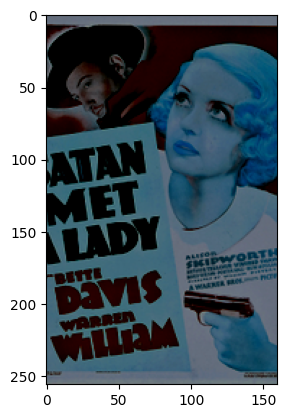

In [12]:
len(dataset['features']), len(dataset['images']), len(dataset['vgg_features']), len(dataset['genres'])

print(dataset.keys())

len(dataset['sequences'])

print(dataset['images'][0].shape)

#Shift the first axis to the last axis
img = np.moveaxis(dataset['images'][0], 0, -1)
plt.imshow(img)

dataset.keys()
print(dataset['word_grams'][0].shape)
print(dataset['imdb_ids'][0])

In [9]:
print(dataset['features'].shape)

(25959, 300)


In [21]:
file_path = '../../../data/mmimdb/dataset'

imdb_id = str(dataset['imdb_ids'][0])
print(imdb_id)


#Extract numerical part of b'9099'
imdb_id = imdb_id[2:-1]
print(imdb_id)
file_name = file_path + '/' + imdb_id + '.json'

with open(file_name, 'r') as f:
    data = json.load(f)


print(data['plot'])

b'0028219'
0028219
["Sardonic detective Shane, thrown out of one town for bringing trouble, heads for home and his ex-partner's detective agency. The business is in a sad way, and Shane, who has had the forethought to provide himself with a 250-dollar commission from an old lady on the train, is welcomed with open arms. When pretty Valerie Purvis walks in the next day willing to pay over the odds to put a tail on the man who did her wrong, Shane's way with the ladies looks like paying off yet again. But things start to go wrong when his partner is murdered, and Shane himself comes home to find his apartment wrecked by a gentlemanly crook who comes back to apologise -- and to tell him a fascinating fairy-story about the fabled Horn of Roland that looks like not being so mythical after all. Miss Purvis wants protection. The police want answers. And all sorts of people want the 'French horn'... but Shane is one jump ahead of everyone all the way. Well, almost."]


In [49]:
file = '../../../data/multimodal_imdb.hdf5'
dataset = IMDBDataset2(file, 0, 15552, vggfeature=True)

In [54]:
print(type(dataset))

print(dataset.get_raw("b\'0092501\'", '../../../data/mmimdb/dataset'))

<class '__main__.IMDBDataset2'>
(['Dragon Ma is back, having rid the seas of the dreaded Pirate Lo. Back on land, he is assigned to the police force, where he is to clean up corruption and crime in a local suburb. Along the way, he is caught up in the fate of several Chinese patriots attempting to secure sympathy and support for their revolutionary cause. The Chinese Manchu government is after these revolutionaries, and anyone that stands in their way is in trouble, even if they are in the police force.', 'Dragon is now transferred to be the police head of Sai Wan district, and has to contend with a gangster kingpin, anti-Manchu revolutionaries, some runaway pirates, Manchu Loyalists and a corrupt police superintendent.'], <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=332x475 at 0x7F8288200EF0>)
